In [1]:
import sys
sys.path.append('../src/')
from vi_hrg import *
from utils import *
from torch import autograd
torch.manual_seed(81)

def noise_r(x, R, rel_var=0.1, epsilon=1e-4):
    rs = torch.distributions.normal.Normal(x, R*rel_var).sample() 
    return torch.clamp(rs, min=0+epsilon, max=R-epsilon)

def noise_phi(x, rel_var=0.1):
    phis = torch.distributions.normal.Normal(x, 2*np.pi*rel_var).sample()
    return phis % (2*np.pi)

N = 40
R = 7.0
alpha = 0.6
T = 0.1

G = HRG(R=R, alpha=alpha, T=T)
r, theta, A = G.generate(N)
#G.show()
#G.plot()

In [2]:
def bootstrap(r, phi, A, n, ind_dupl=None):
    n_old = len(A)
    assert n > n_old
    n_dupl = n - n_old
    if ind_dupl is None:
        ind_dupl = list(torch.randint(n_old, torch.Size([n_dupl])))
    A_new = torch.zeros([n,n])
    A_new[:n_old, :n_old] = A.detach().clone()
    r_new = torch.zeros([n])
    r_new[:n_old] = r.detach().clone()
    phi_new = torch.zeros([n])
    phi_new[:n_old] = phi.detach().clone()
    
    list_dupl = []
    for i in range(n_dupl):
        A_new[n_old+i,:]= A_new[ind_dupl[i],:]
        A_new[:,n_old+i]= A_new[:,ind_dupl[i]]
        A_new[n_old+i, ind_dupl[i]] = 1.
        A_new[ind_dupl[i], n_old+i] = 1.
        list_dupl.append([ind_dupl[i],n_old+i])
        r_new[n_old+i] = r_new[ind_dupl[i]]
        phi_new[n_old+i] = phi_new[ind_dupl[i]]
    dupl = torch.tensor(list_dupl)
    
    return r_new.clone(), phi_new.clone(), A_new.clone(), dupl

# Original

In [3]:

r_zzz = noise_r(r, R, rel_var=0.1)
phi_zzz = noise_phi(theta, 0.1)

r_loc_init = logit(r/R)
r_scale_init = (torch.ones([N])/8).log()
phi_loc_init = polar2cart(1, theta)
phi_scale_init = (torch.ones([N])*100).log()
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()
dataloader = DataLoader(EdgesDataset(A, directed=False, diagonal=False), 
                        batch_size=int(N*4), num_workers=0, shuffle=True)
vi = VI_HRG(N,20, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':phi_scale_init, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init},
           fixed={'R':None, 
                  'T':0.1,
                  'alpha':0.75},
           priors={'R_p':torch.tensor([20., 0.4]), 
                    'T_p':torch.tensor([1., 15.]),
                    'alpha_p':torch.tensor([27., 0.03])},)

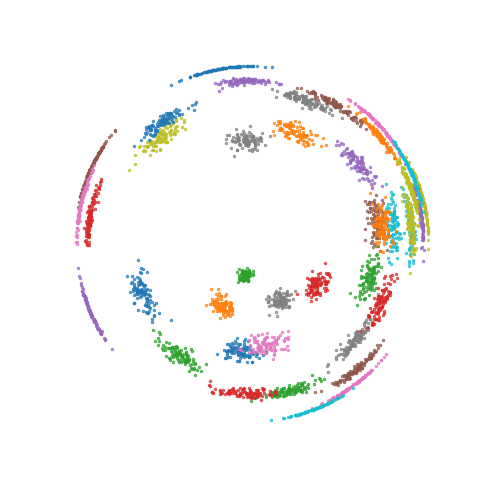

In [4]:
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
#ax.set_rmax(R*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
#print('Likelihood:', vi.likelihood())

In [5]:
vi.train(dataloader, lrs=[0.1, 0.05, 0.01], debug=False, epochs=[60,60,120])

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 452.91 | Epoch time 0.13
Epoch 2 | LR: 0.10 | Total loss: 358.36 | Epoch time 0.11
Epoch 3 | LR: 0.10 | Total loss: 309.68 | Epoch time 0.12
Epoch 4 | LR: 0.10 | Total loss: 277.25 | Epoch time 0.11
Epoch 5 | LR: 0.10 | Total loss: 273.07 | Epoch time 0.11
Epoch 6 | LR: 0.10 | Total loss: 231.41 | Epoch time 0.10
Epoch 7 | LR: 0.10 | Total loss: 254.12 | Epoch time 0.12
Epoch 8 | LR: 0.10 | Total loss: 234.31 | Epoch time 0.11
Epoch 9 | LR: 0.10 | Total loss: 224.25 | Epoch time 0.13
Epoch 10 | LR: 0.10 | Total loss: 195.44 | Epoch time 0.14
Epoch 11 | LR: 0.10 | Total loss: 206.14 | Epoch time 0.13
Epoch 12 | LR: 0.10 | Total loss: 208.98 | Epoch time 0.11
Epoch 13 | LR: 0.10 | Total loss: 207.49 | Epoch time 0.11
Epoch 14 | LR: 0.10 | Total loss: 232.47 | Epoch time 0.10
Epoch 15 | LR: 0.10 | Total loss: 199.84 | Epoch time 0.12
Epoch 16 | LR: 0.10 | Total loss: 233.11 | Epoch time 0.10
Epoch 17 | LR: 0.10 | Total loss: 

Epoch 140 | LR: 0.01 | Total loss: 107.67 | Epoch time 0.10
Epoch 141 | LR: 0.01 | Total loss: 107.74 | Epoch time 0.11
Epoch 142 | LR: 0.01 | Total loss: 113.47 | Epoch time 0.10
Epoch 143 | LR: 0.01 | Total loss: 105.67 | Epoch time 0.12
Epoch 144 | LR: 0.01 | Total loss: 113.49 | Epoch time 0.10
Epoch 145 | LR: 0.01 | Total loss: 110.86 | Epoch time 0.12
Epoch 146 | LR: 0.01 | Total loss: 111.54 | Epoch time 0.10
Epoch 147 | LR: 0.01 | Total loss: 113.37 | Epoch time 0.11
Epoch 148 | LR: 0.01 | Total loss: 112.67 | Epoch time 0.10
Epoch 149 | LR: 0.01 | Total loss: 127.39 | Epoch time 0.11
Epoch 150 | LR: 0.01 | Total loss: 111.19 | Epoch time 0.10
Epoch 151 | LR: 0.01 | Total loss: 116.75 | Epoch time 0.11
Epoch 152 | LR: 0.01 | Total loss: 108.71 | Epoch time 0.10
Epoch 153 | LR: 0.01 | Total loss: 109.45 | Epoch time 0.11
Epoch 154 | LR: 0.01 | Total loss: 107.44 | Epoch time 0.10
Epoch 155 | LR: 0.01 | Total loss: 100.21 | Epoch time 0.11
Epoch 156 | LR: 0.01 | Total loss: 106.8

In [6]:
r_, phi_, R_, T_, alpha_ = vi.qmean()
R_, T_, alpha_

(tensor(7.0647, dtype=torch.float64),
 tensor(0.1000, dtype=torch.float64),
 tensor(0.7500, dtype=torch.float64))

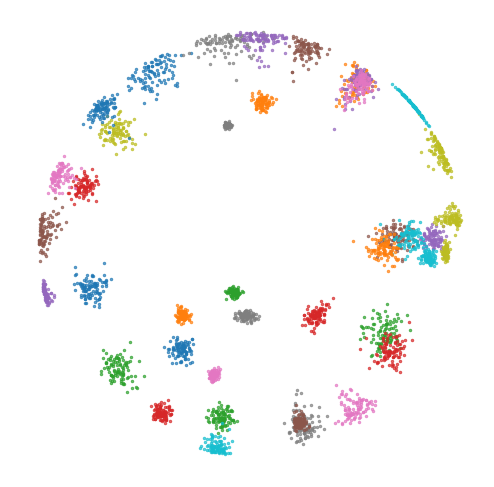

Likelihood: -58.91227337245691


In [7]:
nodes = vi.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
print('Likelihood:', vi.likelihood())

# Duplicates (x10)

In [8]:
N_dupl = 400
r2, phi2, A2, dupl = bootstrap(r, theta, A, N_dupl)

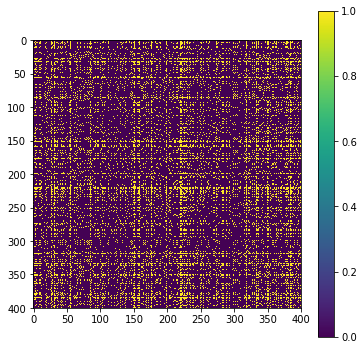

In [9]:
G_dupl = HRG(R=R, alpha=alpha, T=T)
G_dupl.r, G_dupl.theta, G_dupl.A = noise_r(r2,R,0.02), noise_phi(phi2, 0.01), A2
G_dupl.show()
#G_dupl.plot(figsize=(10,10), n_orig=40)

In [10]:
r_loc_init = logit(noise_r(r2,R,0.02)/R)
r_scale_init = (torch.ones([N_dupl])/8).log()
phi_loc_init = polar2cart(1, noise_phi(phi2, 0.01))
phi_scale_init = (torch.ones([N_dupl])*100).log()
R_conc_init = torch.tensor(10.).log()
R_scale_init = torch.tensor(1.).log()
alpha_conc_init = torch.tensor(.5).log()
alpha_scale_init = torch.tensor(.5).log()
T_init = torch.tensor([3.,10.]).log()
dataloader2 = DataLoader(EdgesDataset(A2, directed=False, diagonal=False), 
                        batch_size=int(N_dupl*4), num_workers=0, shuffle=True)
vi2 = VI_HRG(N_dupl,20, init_values={'rs_loc':r_loc_init,
                                'rs_scale':r_scale_init,
                              'phis_loc':phi_loc_init,
                              'phis_scale':phi_scale_init, 
                              'R_conc':R_conc_init, 
                              'R_scale':R_scale_init,
                              'alpha_conc':alpha_conc_init,
                              'alpha_scale':alpha_scale_init,
                              'T':T_init},
           fixed={'R':None, 
                  'T':0.1,
                  'alpha':0.75},
           priors={'R_p':torch.tensor([20., 0.4]), 
                    'T_p':torch.tensor([1., 15.]),
                    'alpha_p':torch.tensor([27., 0.03])})

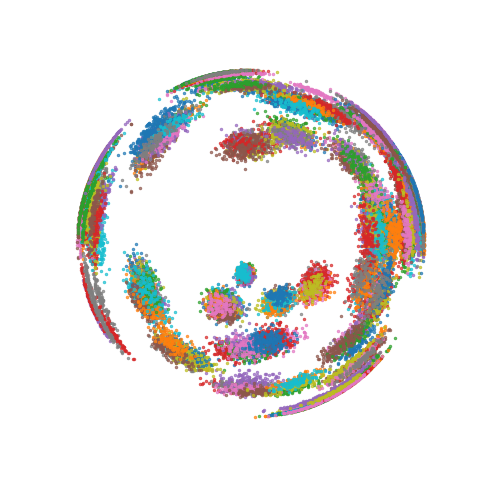

In [11]:
nodes = vi2.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N_dupl):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
#ax.set_rmax(R*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
#print('Likelihood:', vi.likelihood())

In [12]:
vi2.train(dataloader2, lrs=[0.1, 0.05, 0.01], debug=False, epochs=[60,60,120])

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 26801.73 | Epoch time 5.16
Epoch 2 | LR: 0.10 | Total loss: 17936.07 | Epoch time 5.62
Epoch 3 | LR: 0.10 | Total loss: 14505.38 | Epoch time 5.47
Epoch 4 | LR: 0.10 | Total loss: 12172.27 | Epoch time 5.44
Epoch 5 | LR: 0.10 | Total loss: 10529.49 | Epoch time 6.13
Epoch 6 | LR: 0.10 | Total loss: 9014.02 | Epoch time 6.32
Epoch 7 | LR: 0.10 | Total loss: 8412.02 | Epoch time 5.21
Epoch 8 | LR: 0.10 | Total loss: 7377.71 | Epoch time 5.49
Epoch 9 | LR: 0.10 | Total loss: 6952.27 | Epoch time 7.15
Epoch 10 | LR: 0.10 | Total loss: 5988.91 | Epoch time 7.00
Epoch 11 | LR: 0.10 | Total loss: 5551.69 | Epoch time 7.24
Epoch 12 | LR: 0.10 | Total loss: 5227.58 | Epoch time 6.66
Epoch 13 | LR: 0.10 | Total loss: 4646.44 | Epoch time 6.88
Epoch 14 | LR: 0.10 | Total loss: 4444.70 | Epoch time 7.81
Epoch 15 | LR: 0.10 | Total loss: 4092.58 | Epoch time 10.43
Epoch 16 | LR: 0.10 | Total loss: 3744.62 | Epoch time 6.07
Epoch 17 | L

 ../src/utils.py:126: UserWarning:edes_prob_arg has NaN in it! 


Epoch 31 | LR: 0.10 | Total loss: 2406.70 | Epoch time 10.24
Epoch 32 | LR: 0.10 | Total loss: 2413.48 | Epoch time 9.94
Epoch 33 | LR: 0.10 | Total loss: 2343.93 | Epoch time 10.08
Epoch 34 | LR: 0.10 | Total loss: 2311.88 | Epoch time 10.54
Epoch 35 | LR: 0.10 | Total loss: 2364.29 | Epoch time 10.07
Epoch 36 | LR: 0.10 | Total loss: 2293.96 | Epoch time 9.97
Epoch 37 | LR: 0.10 | Total loss: 2315.95 | Epoch time 10.16
Epoch 38 | LR: 0.10 | Total loss: 2268.64 | Epoch time 10.23
Epoch 39 | LR: 0.10 | Total loss: 2186.88 | Epoch time 10.10
Epoch 40 | LR: 0.10 | Total loss: 2258.31 | Epoch time 10.20
Epoch 41 | LR: 0.10 | Total loss: 2142.28 | Epoch time 10.19
Epoch 42 | LR: 0.10 | Total loss: 2263.54 | Epoch time 10.71
Epoch 43 | LR: 0.10 | Total loss: 2141.41 | Epoch time 10.18
Epoch 44 | LR: 0.10 | Total loss: 2162.91 | Epoch time 9.92
Epoch 45 | LR: 0.10 | Total loss: 2102.97 | Epoch time 10.57
Epoch 46 | LR: 0.10 | Total loss: 2076.56 | Epoch time 10.27
Epoch 47 | LR: 0.10 | Total

Epoch 165 | LR: 0.01 | Total loss: 1663.97 | Epoch time 11.58
Epoch 166 | LR: 0.01 | Total loss: 1649.07 | Epoch time 7.75
Epoch 167 | LR: 0.01 | Total loss: 1630.98 | Epoch time 7.01
Epoch 168 | LR: 0.01 | Total loss: 1682.91 | Epoch time 7.57
Epoch 169 | LR: 0.01 | Total loss: 1623.35 | Epoch time 7.80
Epoch 170 | LR: 0.01 | Total loss: 1617.47 | Epoch time 7.48
Epoch 171 | LR: 0.01 | Total loss: 1679.76 | Epoch time 9.68
Epoch 172 | LR: 0.01 | Total loss: 1632.07 | Epoch time 10.57
Epoch 173 | LR: 0.01 | Total loss: 1632.73 | Epoch time 10.73
Epoch 174 | LR: 0.01 | Total loss: 1688.66 | Epoch time 9.93
Epoch 175 | LR: 0.01 | Total loss: 1617.53 | Epoch time 10.14
Epoch 176 | LR: 0.01 | Total loss: 1686.89 | Epoch time 10.52
Epoch 177 | LR: 0.01 | Total loss: 1626.86 | Epoch time 10.55
Epoch 178 | LR: 0.01 | Total loss: 1615.38 | Epoch time 9.87
Epoch 179 | LR: 0.01 | Total loss: 1671.20 | Epoch time 10.61
Epoch 180 | LR: 0.01 | Total loss: 1641.47 | Epoch time 10.40
Epoch 181 | LR: 

In [13]:
r_, phi_, R_, T_, alpha_ = vi2.qmean()
R_, T_, alpha_

(tensor(7.7806, dtype=torch.float64),
 tensor(0.1000, dtype=torch.float64),
 tensor(0.7500, dtype=torch.float64))

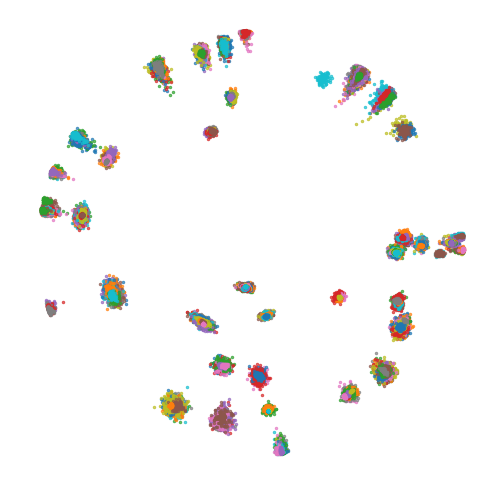

Likelihood: -860.91944411442


In [16]:
nodes = vi2.posterior_samples(100)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection='polar')
for i in range(N_dupl):
    ax.scatter(nodes[:,i,1].numpy(), nodes[:,i,0].numpy(), alpha=0.7, s=6)
#ax.scatter(theta.numpy(), r.numpy(), alpha=0.7, s=6, color='black')
#for link in A.nonzero():
#    ax.plot(theta[link].numpy(), r[link].numpy(), color='gray', alpha=0.2)
ax.set_rmax(R_*1.02)
ax.set_rticks([]) 
ax.set_axis_off()
plt.show()
print('Likelihood:', vi2.likelihood())

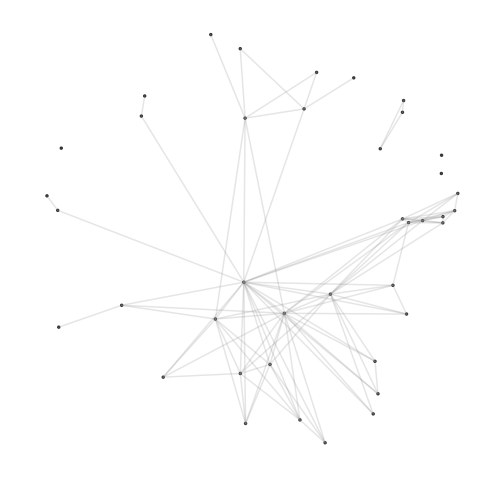

In [15]:
G.plot(figsize=(8,8))